In [96]:
import torch
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.draw import random_shapes
import cv2
import random
import torch.nn.functional as f
from numba import njit
from scipy.stats import norm

In [2]:
torch.cuda.is_available()

True

In [3]:
print(torch.__version__)

1.1.0


In [4]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [5]:
#Function to generate a dimxdim image of a random shape of a size between given bounds
def shape_gen(dim, minimum,maximum):
    x = random_shapes((dim, dim), max_shapes=1, multichannel=False, intensity_range=(0,0),min_size = minimum, max_size=maximum)[0]
    x = (-1*x+255)/255
    return(x)

In [6]:
imgDim = 16 #image dimension
mov_length = 8 

In [175]:
#Create array of start images
images_seq = [shape_gen(imgDim,4,10) for i in range(1000)]
images_seq = np.array(images_seq)
images_seq = np.expand_dims(images_seq,1)

test_seq = [shape_gen(imgDim,5,8) for i in range(1000)]
test_seq = np.array(test_seq)
test_seq = np.expand_dims(test_seq,1)

In [176]:
#For a given collection of start images with (n,1,k,k), with n images of dimension k by k. Trans_range is one-sided,
#so trans_range = 4 allows translations of 4 up or down, 4 left or right. same for rot_center, how much the center of 
#rotation can shift to one-side both up/down. rot_angle is maximum angle in DEGREES
def rand_trans(data, trans_range, rot_center, rot_angle): 
    def M_gen(i):
        hor = random.randint(-trans_range, trans_range)
        ver = random.randint(-trans_range, trans_range)
        x = np.float32([[1,0,hor],[0,1,ver]]) #create translation matrix
        
        return(x)
    
    Z = np.array([M_gen(i) for i in range(data.shape[0])])
    
    return(Z)
    

In [177]:
M = rand_trans(images_seq, 1, 0, 45)
M2 = rand_trans(test_seq, 1, 0, 45)

In [178]:
#for a given collection of start images - "data" - and their associated transformations -"transform", one for each start image-
#will generate a movie sequence of the desired length. note "data" should be np.array of shape (n,1,k,k).
def image_gen(data, transform, movie_len,imgDim):
    X = data
    for j in range(movie_len-1):
        Y = np.array([cv2.warpAffine(X[i,j],transform[i],(imgDim,imgDim)) for i in range(data.shape[0])])
        Y = np.expand_dims(Y,1) #add the second axis, which denotes time, to concatenate the images
        X = np.concatenate((X,Y),axis=1)
    
    X = X.reshape(X.shape[0],X.shape[1],X.shape[2]**2)
    return(X) #reshape so it's easier to work with

In [179]:
dataNP = image_gen(images_seq, M, mov_length, imgDim)
test_rawNP = image_gen(test_seq, M2, mov_length, imgDim)

data = torch.from_numpy(dataNP).cuda()
data = data.float()

In [180]:
def multi_gen(test_seq, testSize, maxShapes):
    
    #Set up first array, then just loop by concatenating.
    
    test_data = test_seq[np.random.randint(0,test_seq.shape[0],maxShapes)] #choose random number of movie sequences
    test_data = np.sum(test_data,axis= 0) #sum them together
    test_data[test_data > 1] = 1 #cap images at 1
    test_data = np.expand_dims(test_data, axis = 0) #add back the extra first axis, which indexes every movie sequence
    
    for datum in range(1,testSize):
        subset = test_seq[np.random.randint(0,test_seq.shape[0],maxShapes)]
        subset = np.sum(subset,axis=0)
        subset[subset > 1] = 1
        subset = np.expand_dims(subset, axis = 0)
        test_data = np.concatenate((test_data,subset),axis=0)
    
    return(test_data)

In [181]:
testNP = multi_gen(test_rawNP, 100, 2)
test = torch.from_numpy(testNP)
test = test.float().cuda()

In [182]:
#Rationale: since movies of multiple objects, with overlap, will just be sum of two images with values capped at 255,
#want transforms to reflect this ceiling like behavior or else prediction might be bad. 
#Will use a smooth squashing function, tanh.

def squash(x):
    y = 1.3*torch.tanh(x) #1.3 so will be approxiamtely linear on [-1,1]
    return(y)

def squash_deriv(x):
    y = 1.3*(1-torch.tanh(x)**2)
    return(y)

def squashNP(x):
    y = 1.3*np.tanh(x) #1.3 so will be approxiamtely linear on [-1,1]
    return(y)

def squash_derivNP(x):
    y = 1.3*(1-np.tanh(x)**2)
    return(y)

In [150]:
numTransforms = 16
trainSteps = 1500
batchSize = 25 #training 
sparsePen = 8
derivPen = 4
epsilon = 3 #variance of normal desntiy in the smoothed bump function.
eta = .01 #learning rate of phi, the dictionary of transforms
eta2 = .015 #learning rate of beta, the transform coeff
eta3 = 10 #Learning rate of radii
eta4 = 10 #Learning rate of center
numInference = 150 #arbitrary
numInf2 = 25
betaStep = 10 #FOR TRAINED TRANSFORMS. mini cycle for beta
attStep = 10 #FOR TRAINED TRANSFORMS. mini cycle for center/radii

In [16]:
# norm_beta = torch.norm(beta,dim=2) #normalize btk, for all batches and time
# deriv_part1 = norm_beta/(norm_beta**4+1)
# deriv_part1 = deriv_part1.unsqueeze(2)

In [17]:
# deriv_part1.size()

In [18]:
#Training algorithm, image sequences with one shape. No need to infer center/radii yet.
def timeDeriv(beta):
    #assuming beta has shape btk, where k for trans, t for length, B for number of images (usually batch size)
    
    Zeroes = torch.zeros((beta.size()[0],1,beta.size()[2])).cuda()
    timeDiff = beta[:,1:,:] - beta[:,:(beta.size(1)-1),:]
    tmDiffnorm = torch.norm(timeDiff, p=1, dim=1)
    deriv_part1 = (tmDiffnorm/(tmDiffnorm**2+1)).unsqueeze(1) #normalize across time
    X = torch.cat((Zeroes, timeDiff), 1)
    Y = torch.cat((timeDiff,Zeroes), 1)
    Z = torch.sign(X) - torch.sign(Y)
    timeBeta = deriv_part1*Z
    
    return(timeBeta)

def timeDerivNP(beta):
    #assuming beta has shape btk, where k for trans, t for length, B for number of images (usually batch size)
    
    Zeroes = np.zeros((beta.shape[0],1,beta.shape[2]))
    timeDiff = np.diff(beta, axis= 1)
    tmDiffnorm = np.linalg.norm(timeDiff, ord = 1, axis=1)#normalize across time
    deriv_part1 = tmDiffnorm/(tmDiffnorm**2+1) 
    deriv_part1 = np.expand_dims(deriv_part1, axis = 1)
    X = np.concatenate((Zeroes, timeDiff), axis=1)
    Y = np.concatenate((timeDiff,Zeroes), axis =1)
    Z = np.sign(X)-np.sign(Y)
    timeBeta = np.multiply(deriv_part1,Z)
    
    return(timeBeta)


def sparseDeriv(beta):
    #assume beta has shape btk.
    
    norm_beta = torch.norm(beta, p = 1, dim=2) #normalize btk, for all batches and time
    deriv_part1 = norm_beta/(norm_beta**2+1)
    deriv_part1 = deriv_part1.unsqueeze(2)
    sparseBeta = deriv_part1*torch.sign(beta)
    
    return(sparseBeta)

def sparseDerivNP(beta):
    #assume beta has shape btk.
    
    norm_beta = np.linalg.norm(beta,ord=1, axis=2) #normalize btk, for all batches and time
    deriv_part1 = norm_beta/(norm_beta**2+1)
    deriv_part1 = np.expand_dims(deriv_part1, axis = 2)
    sparseBeta = np.multiply(deriv_part1,np.sign(beta))
    
    return(sparseBeta)

def inferBeta(Input, Output, phi, sparsePen, derivPen, eta2):
    #Assume data has shape (B, T, n2), where number of images(usually batch size) , T is time, and n2 is n^2 for nxn image
    #phi is of shape (i,i',k) where i,i' denote image dim, k denotes transform, T is time, and B is batch
    #Input are first T-1 frames. Output are frames 2 to T. Infer i^th frame from previous.
    
    beta = torch.ones((Input.size()[0],Input.size()[1],phi.size()[2])).cuda() #initialize beta at 0. beta is shape btk
    
    for step in range(numInference):
        predictions = torch.einsum('btk,ijk,btj -> bti', beta, phi, Input)
        dTanh = squash_deriv(predictions)
        error = Output - squash(predictions)
        delta = torch.einsum('bti,bti -> bti', error, dTanh)
        dBeta = torch.einsum('bti,ijk, btj -> btk', delta, phi, Input) - sparsePen*sparseDeriv(beta) - derivPen*timeDeriv(beta)
        beta += eta2*dBeta
        
    return(beta)

    
def learnTransform(Input, Output, phi, beta, eta, batchSize):
    
    predictions = torch.einsum('btk,ijk,btj -> bti', beta, phi, Input)
    error = Output - squash(predictions)
    dTanh = squash_deriv(predictions)
    delta = torch.einsum('bti,bti -> bti', error, dTanh)
    dPhi = torch.einsum('bti, btj, btk -> ijk', delta, Input, beta)
    phi += (eta/batchSize)*dPhi
    
    return(phi, error)
    

In [19]:
# norm_beta = torch.norm(beta,dim=2) #normalize btk, for all batches and time
# deriv_part1 = norm_beta/(norm_beta**2+1)
# deriv_part1 = deriv_part1.unsqueeze(2)
# dBeta = deriv_part1*beta

In [20]:
# timeDeriv = np.diff(beta, axis= 1)
# timeDeriv.shape

In [21]:
#Traning algo, image sequences with one shape.

def TrainMore(dataset, phi, trainSteps, batchSize, sparsePen, derivPen, eta, eta2, numInference, numTransforms):
    
    #intialize phi
    dim = dataset.size()[2]
    
    #ax = plt.subplot(1,1,1)
    #start training
    for trial in range(trainSteps):
        
        data_batch = dataset[np.random.randint(0,dataset.size()[0],batchSize)] #create random batch
        Input = data_batch[:,:(dataset.size()[1]-1),:] #will predict next frame from these
        Output = data_batch[:,1:,:] #the frames to be predicted

        #Find beta, fix, then optimize phi
        beta = inferBeta(Input, Output, phi, sparsePen, derivPen, eta2)
        phi, error = learnTransform(Input, Output, phi, beta, eta, batchSize)

        #renormalize by making transforms have norm 1.
        #phi = phi/(torch.abs(phi).max(axis=(0,1),keepdims=True))
        phi = (f.normalize(phi.view(dim**2,numTransforms),dim=0)).view(dim,dim,numTransforms)
#         phi = torch.clamp(phi, max = 1.0, min = 0)


        if trial%10 == 0: #print every 10 steps
            normError = torch.norm(error).item()
            print('trial: %s ; NormedLoss: %s' % (trial,normError))
        else:
            print('trial: %s' % trial, end='\r')
#             normError = torch.norm(error).item()
#             print('trial: %s ; NormedLoss: %s' % (trial,normError))
#     plt.show()
    return(phi)
    

In [22]:
# #Use this to check what SparsePen/derivPen should be. For 16x16, 1/60 and 1/90 for Sparse/Deriv respectively seems
# #to be a good starting point relative to total batch-wide normedError. Maybe want a little higher

# data_batch = data[np.random.randint(0,data.size()[0],batchSize)] #create random batch
# Input = data_batch[:,:(data.size()[1]-1),:] #will predict next frame from these
# Output = data_batch[:,1:,:] #the frames to be predicted


# dim = data.size()[2]
# phi = torch.rand(dim, dim ,numTransforms).cuda()+.0001 #n2 x n2 x 15. added small number to prevent dividing by zero.


# #Find beta, fix, then optimize phi
# beta = inferBeta(Input, Output, phi, sparsePen, derivPen, eta2)
# phi, error = learnTransform(Input, Output, phi, beta, eta, batchSize)

# #renormalize by making transforms have norm 1.
# #phi = phi/(torch.abs(phi).max(axis=(0,1),keepdims=True))
# phi = (f.normalize(phi.view(dim**2,numTransforms),dim=0)).view(dim,dim,numTransforms)

# timeDiff = beta[:,1:,:] - beta[:,:(beta.size(1)-1),:]
# tmDiffnorm = torch.norm(timeDiff,dim=1)

# print('sparse: %s  time: %s  error: %s' % (torch.log(torch.norm(beta)**4 + 1),torch.log(torch.norm(timeDiff)**4 + 1),torch.norm(error)))

In [23]:
# print('sparse: %s  time: %s  error: %s' % (torch.log(torch.norm(beta)**4 + 1),torch.log(torch.norm(timeDiff)**4 + 1),torch.norm(error)))

In [24]:
#Traning algo, image sequences with one shape.

def Training1(dataset, trainSteps, batchSize, sparsePen, derivPen, eta, eta2, numInference, numTransforms):
    
    #intialize phi
    dim = dataset.size()[2]
    phi = torch.rand(dim, dim ,numTransforms).cuda()+.0001 #n2 x n2 x 15. added small number to prevent dividing by zero.
    
    #ax = plt.subplot(1,1,1)
#start training
#start training. want to intially encourage dictionary elements to be distinct and time coherent, so double penalties for first few runs.

    eta_phase2 = eta*.5
    eta_phase3 = eta*.25
    eta_phase4 = eta*.125
    sparsePen_hold = sparsePen
    derivPen_hold = derivPen
    for trial in range(trainSteps): #iteratively relax learning rate
        if trial <= trainSteps/8:
            sparsePen = sparsePen_hold*2
            derivPen = derivPen_hold*2
        elif trial > trainSteps/8 and trial <= .5*trainSteps:
            eta= eta_phase2
            sparsePen = sparsePen_hold
            derivPen = derivPen_hold
        elif trial > .5*trainSteps and trial <= .75*trainSteps:
            eta = eta_phase3 
        else:
            eta = eta_phase4
    
#above code also in case want to intitally force algo to choose sparse, time-consistent soltuions to get good "initializations"
        
        data_batch = dataset[np.random.randint(0,dataset.size()[0],batchSize)] #create random batch
        Input = data_batch[:,:(dataset.size()[1]-1),:] #will predict next frame from these
        Output = data_batch[:,1:,:] #the frames to be predicted

        #Find beta, fix, then optimize phi
        beta = inferBeta(Input, Output, phi, sparsePen, derivPen, eta2)
        phi, error = learnTransform(Input, Output, phi, beta, eta, batchSize)

        #renormalize by making transforms have norm 1.
        #phi = phi/(torch.abs(phi).max(axis=(0,1),keepdims=True))
        phi = (f.normalize(phi.view(dim**2,numTransforms),dim=0)).view(dim,dim,numTransforms)
        timeDiff = beta[:,1:,:] - beta[:,:(beta.size(1)-1),:]


        if trial%10 == 0: #print every 10 steps
            print('Trial: %s  errorL2: %s  sparseL1: %s  timeL1: %s' % (trial, round(torch.norm(error).item(),3),.5*round(torch.norm(beta, p=1).item(),3),.5*round(torch.norm(timeDiff, p =1).item(),3)))
#             print('trial: %s ; NormedLoss: %s' % (trial,normError))
        else:
            print('Trial: %s  errorL2: %s  sparseL1: %s  timeL1: %s' % (trial, round(torch.norm(error).item(),3),.5*round(torch.norm(beta, p=1).item(),3),.5*round(torch.norm(timeDiff, p =1).item(),3)),end = '\r')
#             print('trial: %s' % trial, end='\r')
#         normError = torch.norm(error).item()
#         print('trial: %s ; NormedLoss: %s' % (trial,normError))
#     plt.show()
    return(phi)
    

In [58]:
#trial where betas intialize at ones, and also add in extra relaxation on learning rate.
learnPhi= Training1(data, trainSteps, batchSize, sparsePen, derivPen, eta, eta2, numInference, numTransforms)

Trial: 0  Norms of -- error: 276.635  sparse: 514.565  time: 728.964
Trial: 10  Norms of -- error: 61.751  sparse: 7.222  time: 10.352
Trial: 20  Norms of -- error: 55.372  sparse: 7.478  time: 9.3029
Trial: 30  Norms of -- error: 52.623  sparse: 6.579  time: 9.743
Trial: 40  Norms of -- error: 46.882  sparse: 6.937  time: 9.344
Trial: 50  Norms of -- error: 47.169  sparse: 6.833  time: 9.077
Trial: 60  Norms of -- error: 45.605  sparse: 6.267  time: 7.545
Trial: 70  Norms of -- error: 47.834  sparse: 7.488  time: 9.256
Trial: 80  Norms of -- error: 45.146  sparse: 6.937  time: 9.102
Trial: 90  Norms of -- error: 44.695  sparse: 6.656  time: 8.639
Trial: 100  Norms of -- error: 42.517  sparse: 7.314  time: 9.657
Trial: 110  Norms of -- error: 38.27  sparse: 5.879  time: 8.2734
Trial: 120  Norms of -- error: 43.705  sparse: 7.52  time: 9.3468
Trial: 130  Norms of -- error: 44.348  sparse: 6.841  time: 8.656
Trial: 140  Norms of -- error: 42.433  sparse: 7.236  time: 8.889
Trial: 150  No

In [79]:
# learnPhiNP = torch.Tensor.numpy(torch.Tensor.cpu(learnPhi))
# np.save("learnPhi10_iterDecay.npy", learnedPhi10NP)

In [25]:
learnPhiNP = np.load("Trial2_learnPhi10_iterDecay.npy")
learnPhi = torch.from_numpy(learnPhiNP).float().cuda()

In [26]:
#Now test learned Phi on dataset
data_batch = data[np.random.randint(0,data.shape[0],batchSize)] #create random batch
Input = data_batch[:,:(data.shape[1]-1),:] #will predict next frame from these
Output = data_batch[:,1:,:] #the frames to be predicted
dim = data.size()[2]
beta = inferBeta(Input, Output, learnPhi, sparsePen, derivPen, eta2)
predictions = torch.einsum('btk,ijk,btj -> bti', beta, learnPhi, Input)
predictionsNP = torch.Tensor.numpy(torch.Tensor.cpu(predictions))
predictionsNP[predictionsNP < 0] = 0
OutputNP = torch.Tensor.numpy(torch.Tensor.cpu(Output))

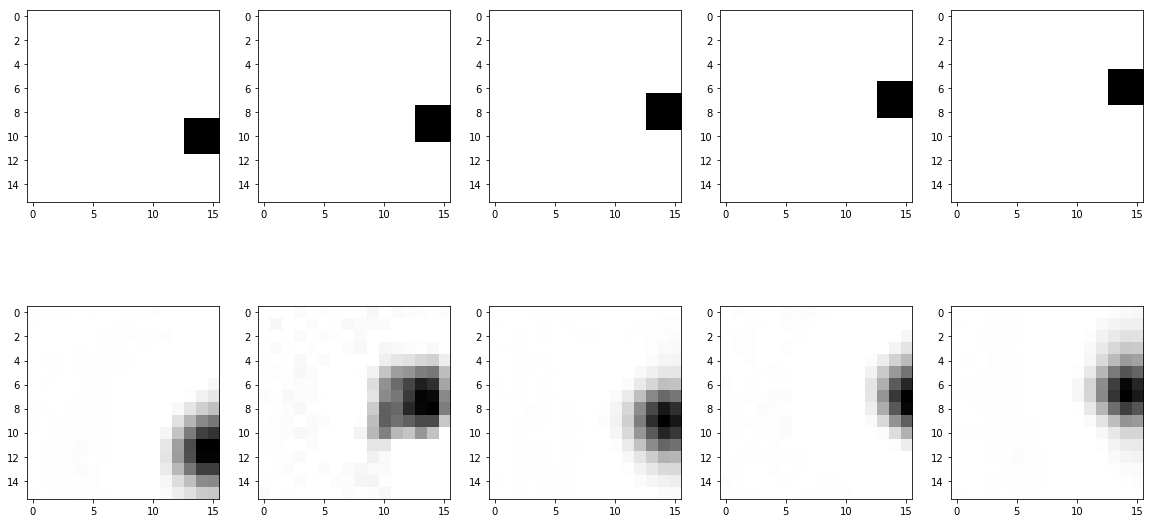

In [64]:
#compare actual to predicted
data_number =17
fig = plt.figure(figsize=(20,10)) #image sequence from dataset
for i in range(10):
    fig.add_subplot(2,5,i+1)
    if i <= 4:
        plt.imshow(OutputNP[data_number,i].reshape((imgDim,imgDim)),cmap = "Greys")
    else:
        plt.imshow(predictionsNP[data_number,i-5].reshape((imgDim,imgDim)),cmap = "Greys")

In [37]:
truePhi.size()

torch.Size([256, 256, 9])

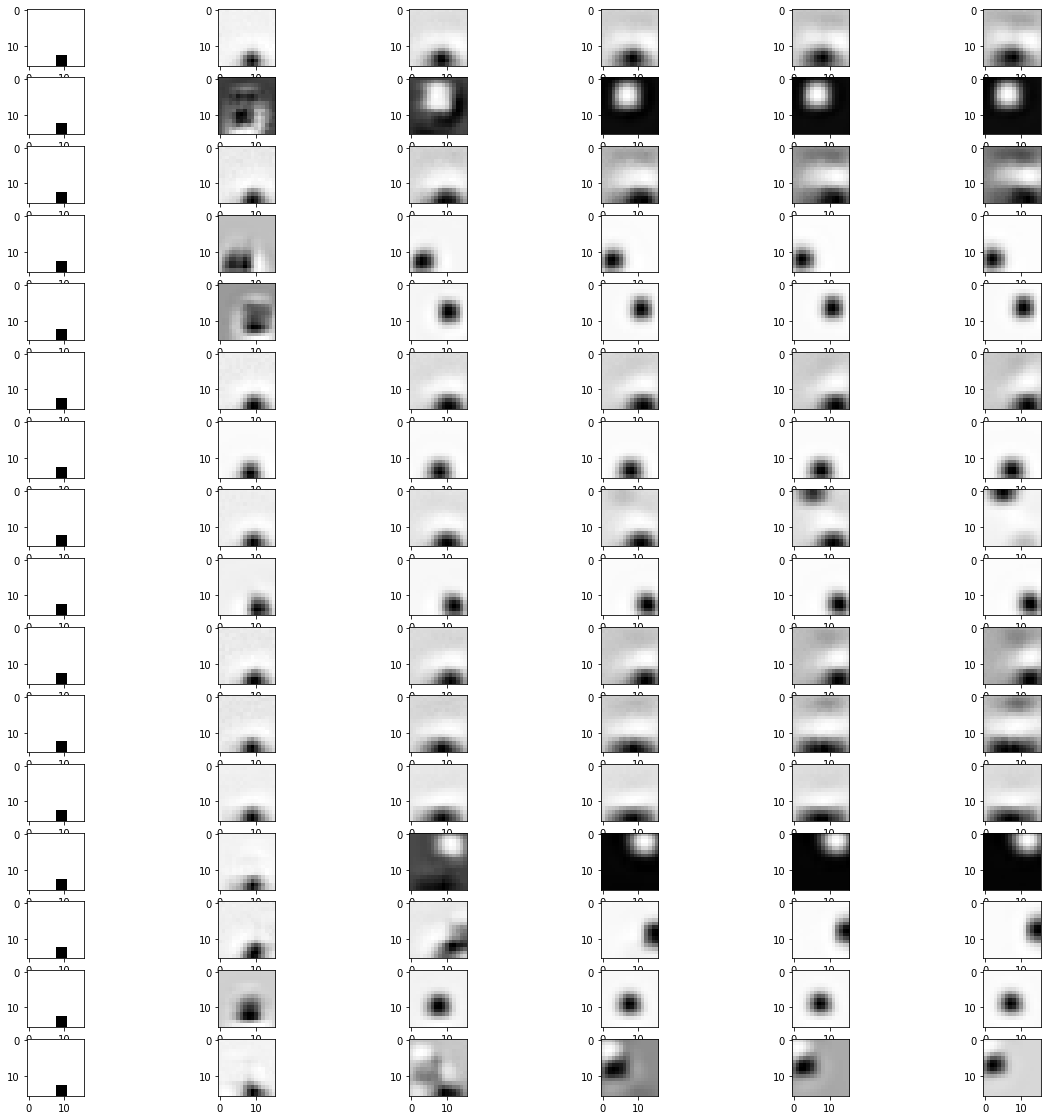

In [26]:
testdata = torch.zeros(numTransforms,6,data.size()[2])
testdata[:,0,:] = data[17,0]
for i in range(numTransforms):
    for j in range(5):
        testdata[i,j+1] = torch.einsum('ij,j -> i', learnPhi[:,:,i],testdata[i,j])
    
testdataNP = torch.Tensor.numpy(torch.Tensor.cpu(testdata))
testdataNP = testdataNP.reshape((testdataNP.shape[0],testdataNP.shape[1],imgDim,imgDim))
fig = plt.figure(figsize=(20,20)) #image sequence from dataset
for i in range(6*numTransforms):
        fig.add_subplot(numTransforms,6,i+1)
        plt.imshow(testdataNP[i//6,i%6],cmap = "Greys")

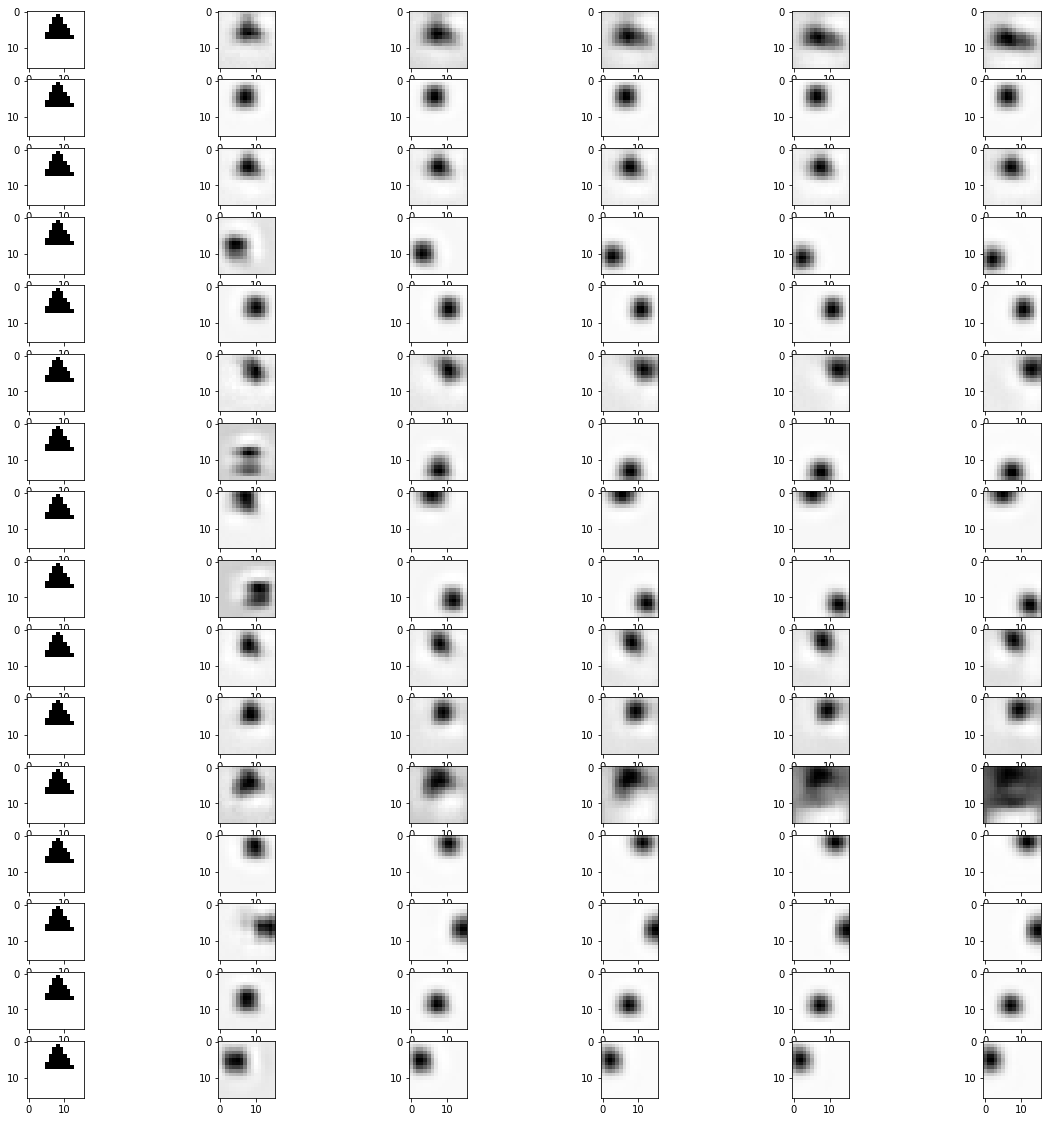

In [65]:
testdata = torch.zeros(numTransforms,6,data.size()[2])
testdata[:,0,:] = data[17,0]
for i in range(numTransforms):
    for j in range(5):
        testdata[i,j+1] = torch.einsum('ij,j -> i', learnPhi[:,:,i],testdata[i,j])
    
testdataNP = torch.Tensor.numpy(torch.Tensor.cpu(testdata))
testdataNP = testdataNP.reshape((testdataNP.shape[0],testdataNP.shape[1],imgDim,imgDim))
fig = plt.figure(figsize=(20,20)) #image sequence from dataset
for i in range(6*numTransforms):
        fig.add_subplot(numTransforms,6,i+1)
        plt.imshow(testdataNP[i//6,i%6],cmap = "Greys")

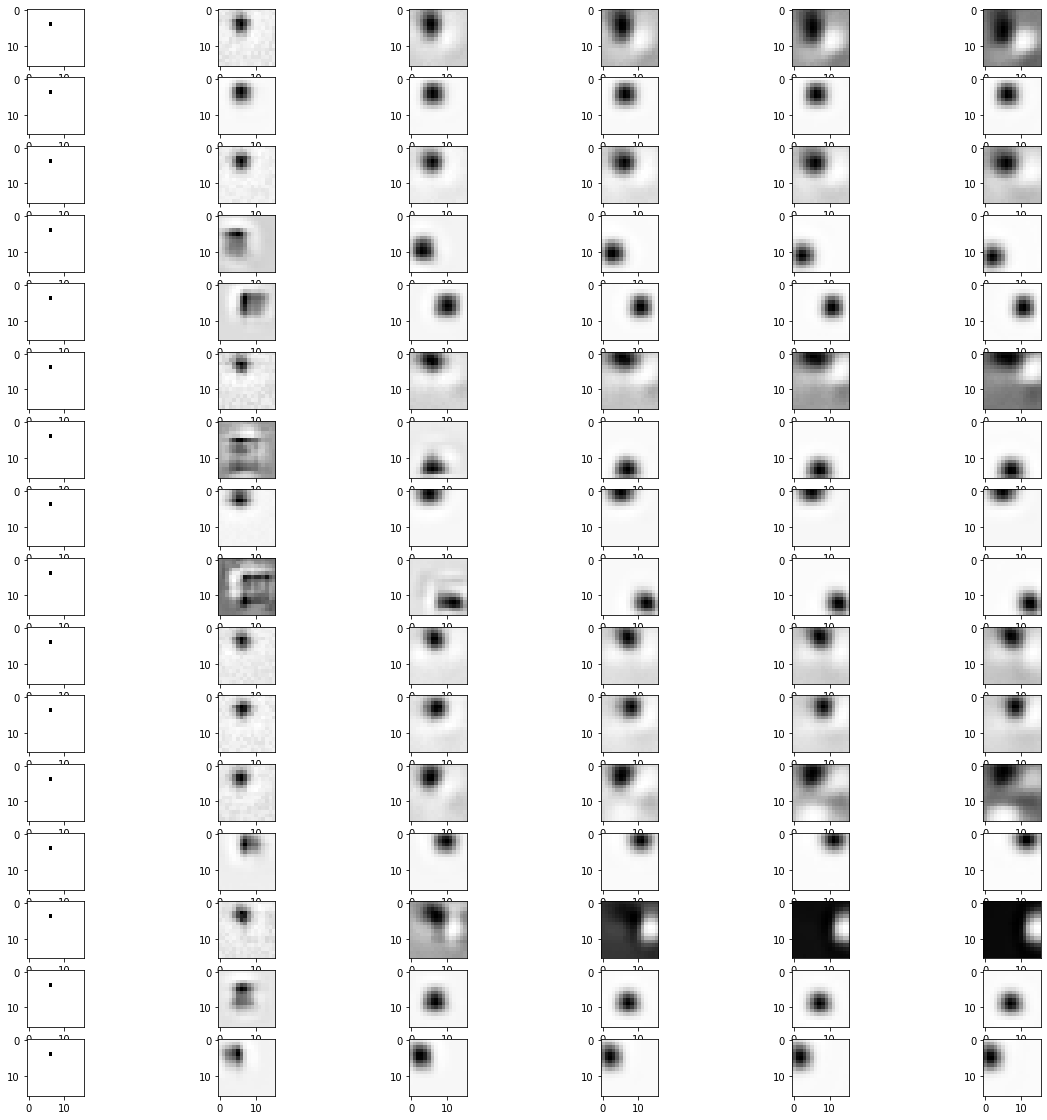

In [24]:
row = 4
col = 6
pos = 16*row + col
testdata = torch.zeros(numTransforms,6,data.size()[2]).cuda()
testdata[:,0,pos] = 1
for i in range(numTransforms):
    for j in range(5):
        testdata[i,j+1] = torch.einsum('ij,j -> i', learnPhi[:,:,i],testdata[i,j])
    
testdataNP = torch.Tensor.numpy(torch.Tensor.cpu(testdata))
testdataNP = testdataNP.reshape((testdataNP.shape[0],testdataNP.shape[1],imgDim,imgDim))
fig = plt.figure(figsize=(20,20)) #image sequence from dataset
for i in range(6*numTransforms):
        fig.add_subplot(numTransforms,6,i+1)
        plt.imshow(testdataNP[i//6,i%6],cmap = "Greys")

#alternate visualization - show where each pixel is sent to.

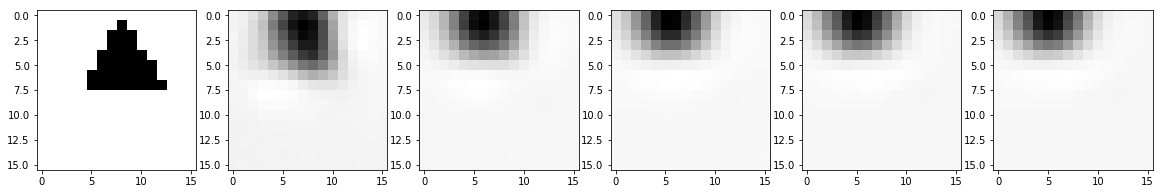

In [66]:
phi_index = 7
testdata = torch.zeros_like(data[17,0:6])
testdata[0] = data[17,0]
for i in range(5):
    testdata[i+1] = torch.einsum('ij,j -> i', learnPhi[:,:,phi_index],testdata[i])
    
testdataNP = torch.Tensor.numpy(torch.Tensor.cpu(testdata))
testdataNP = testdataNP.reshape((testdataNP.shape[0],imgDim,imgDim))
fig = plt.figure(figsize=(20,20)) #image sequence from dataset
for i in range(6):
        fig.add_subplot(1,6,i+1)
        plt.imshow(testdataNP[i],cmap = "Greys")

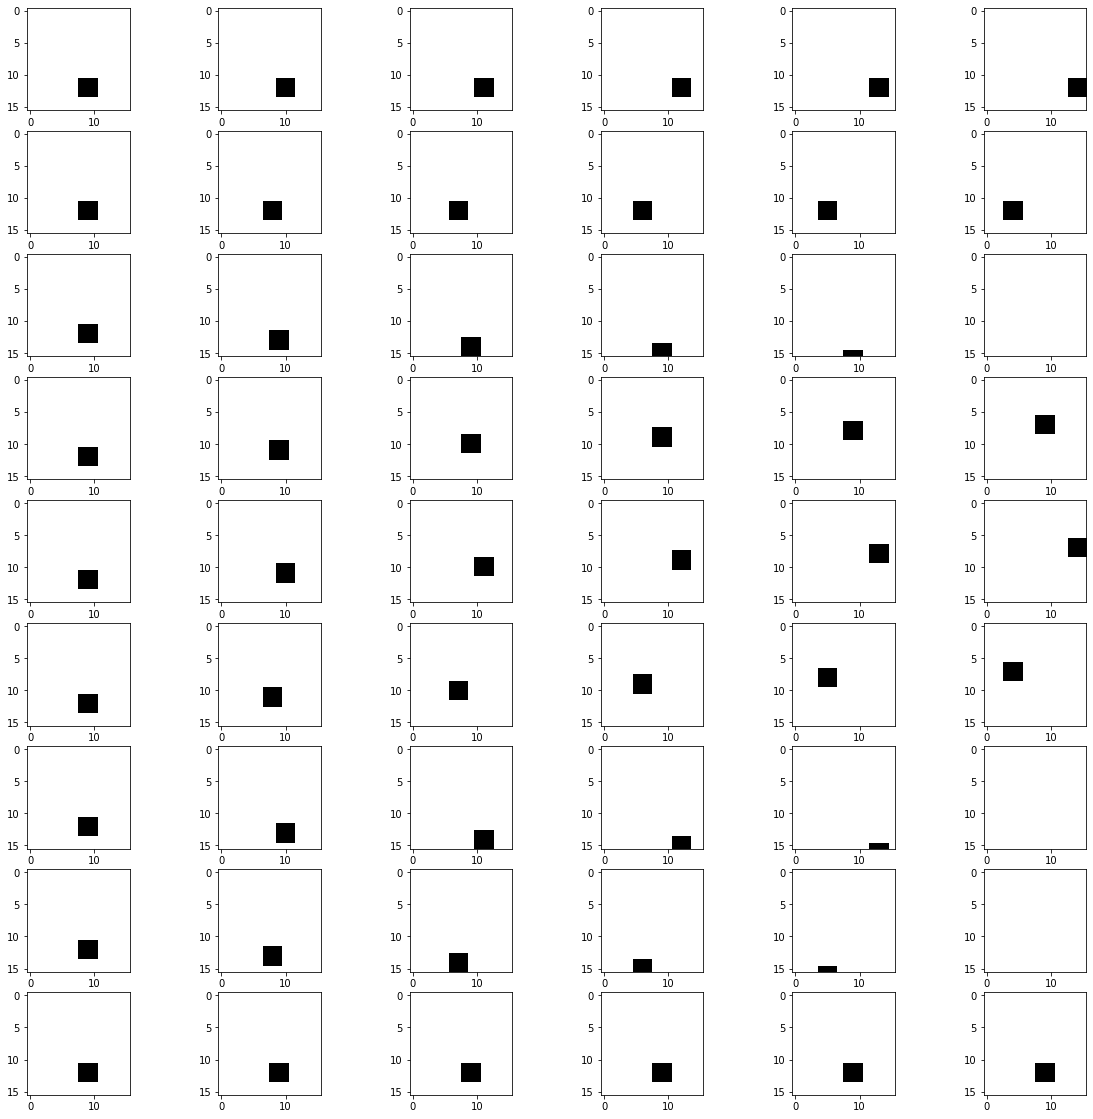

In [60]:
T_right = torch.zeros(imgDim**2,imgDim**2)
for i in range(imgDim**2-1):
        T_right[i,i+1] = 1
T_left = torch.zeros(imgDim**2,imgDim**2)
for i in range(imgDim**2-1):
        T_left[i+1,i] = 1
T_up = torch.zeros(imgDim**2,imgDim**2)
T_up[:15*16,16:] = torch.eye(imgDim**2-imgDim)
T_down = torch.zeros(imgDim**2,imgDim**2)
T_down[16:,:15*16] = torch.eye(imgDim**2-imgDim)
T_ul = torch.mm(T_up,T_left)
T_ur = torch.mm(T_up, T_right)
T_dl = torch.mm(T_down, T_left)
T_dr = torch.mm(T_down, T_right)

truePhi = torch.empty(imgDim**2, imgDim**2,9)
truePhi[:,:,0] = T_left
truePhi[:,:,1] = T_right
truePhi[:,:,2] = T_down
truePhi[:,:,3] = T_up
truePhi[:,:,4] = T_ul
truePhi[:,:,5] = T_ur
truePhi[:,:,6] = T_dl
truePhi[:,:,7] = T_dr
truePhi[:,:,8] = torch.eye(imgDim**2)
truePhi = truePhi.cuda()

testdata = torch.zeros(numTransforms,6,data.size()[2]).cuda()
testdata[:,0,:] = data[17,0]
for i in range(numTransforms):
    for j in range(5):
        testdata[i,j+1] = torch.einsum('ij,j -> i', truePhi[:,:,i],testdata[i,j])
    
testdataNP = torch.Tensor.numpy(torch.Tensor.cpu(testdata))
testdataNP = testdataNP.reshape((testdataNP.shape[0],testdataNP.shape[1],imgDim,imgDim))
fig = plt.figure(figsize=(20,20)) #image sequence from dataset
for i in range(6*numTransforms):
        fig.add_subplot(numTransforms,6,i+1)
        plt.imshow(testdataNP[i//6,i%6],cmap = "Greys")

In [61]:
#Now test learned Phi on dataset
data_batch = data[np.random.randint(0,data.shape[0],batchSize)] #create random batch
Input = data_batch[:,:(data.shape[1]-1),:] #will predict next frame from these
Output = data_batch[:,1:,:] #the frames to be predicted
dim = data.size()[2]
beta_true = inferBeta(Input, Output, truePhi, sparsePen, derivPen, eta2)
predictions = torch.einsum('btk,ijk,btj -> bti', beta, truePhi, Input)
predictionsNP = torch.Tensor.numpy(torch.Tensor.cpu(predictions))
predictionsNP[predictionsNP < 0] = 0
OutputNP = torch.Tensor.numpy(torch.Tensor.cpu(Output))

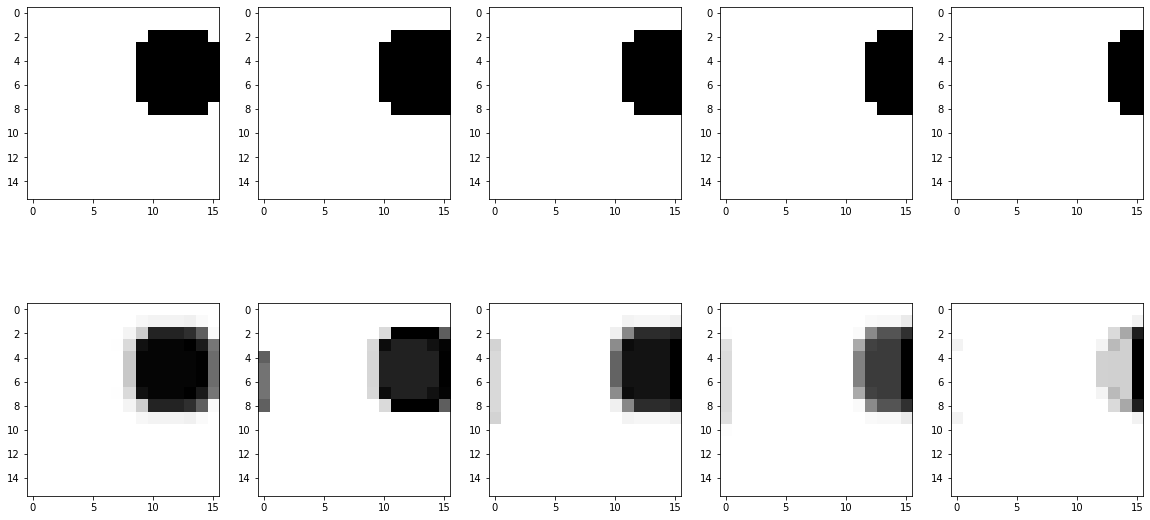

In [68]:
#compare actual to predicted
data_number =6
fig = plt.figure(figsize=(20,10)) #image sequence from dataset
for i in range(10):
    fig.add_subplot(2,5,i+1)
    if i <= 4:
        plt.imshow(OutputNP[data_number,i].reshape((imgDim,imgDim)),cmap = "Greys")
    else:
        plt.imshow(predictionsNP[data_number,i-5].reshape((imgDim,imgDim)),cmap = "Greys")

In [ ]:
# dim = int(np.sqrt(test[0].size()[1]))
# Input = test[0][:(test[0].size()[0]-1)]
# Output = test[0][1:]
# Input2 = Input.view(Input.size()[0],dim,dim) #just reshape to make region of interest indices more natural
# #movie_length = Input2.size()[0]
# movie_length = Input2.size()[0]

# beta = torch.zeros(Input2.size()[0],phi.size()[2]) #initialize beta at 0. beta is shape tk. movie_seq first dim is t
# center = (dim/2)*torch.ones(2,movie_length,phi.size()[2]).cuda() #shape 2tk (2 since center is 2-vector). initialize centers at center of image. each center is 2-vector
# radius2 = ((dim/2+1)**2)*torch.ones(movie_length,phi.size()[2]).cuda() # shape tk.initialize radius2 at r^2, so start off region of interest as entire image

In [ ]:
# fig = plt.figure(figsize=(20,20)) #image sequence from dataset
# for i in range(6):
#         fig.add_subplot(1,6,i+1)
#         plt.imshow(Input2NP[i],cmap = "Greys")

In [ ]:
def normalMatrix(movie_length, dim, center, radius2, epsilon):
    normal_matrix = torch.zeros(center.size()[2], movie_length, dim,dim).cuda() #shape is ktdd, where k is number of transforms, t is time, d is dim of image
    
    
    for k in range(center.size()[2]):
        for t in range(movie_length):
            for i in range(dim):
                for j in range(dim):
                    normal_matrix[k,t,i,j] = (1/np.sqrt(2*np.pi*epsilon))*torch.exp(-(radius2[t,k]-(torch.norm(torch.FloatTensor([i,j]).cuda()-center[:,t,k])**2))**2/(2*epsilon**2))
    
    return(normal_matrix)

def center_ParDeriv(movie_length, dim, center, radius2, epsilon): #calculates partial deriv for center, where each entry is 2-vector
    
    distance_pd = torch.zeros((2,center.size()[2], movie_length, dim, dim)).cuda() #shape 2ktdd
    
    for k in range(distance_pd.size()[0]):
        for t in range(movie_length):
            for i in range(dim):
                for j in range(dim):
                        distance_pd[:,k,t,i,j] = 2*(torch.FloatTensor([i,j]).cuda()-center[:,t,k])
            
    centerPD = distance_pd*(normalMatrix(movie_length,dim,center,radius2,epsilon).unsqueeze(0))
    return(centerPD)

def localImage(Input2, movie_length, dim, center, radius2, epsilon):
    local_matrix = torch.zeros(center.size()[2], movie_length, dim,dim).cuda() #shape is ktdd, where k is number of transforms, t is time, d is dim of image
    
    for k in range(center.size()[2]):
        for t in range(movie_length):
            for i in range(dim):
                for j in range(dim):
                    local_matrix[k,t,i,j] = (torch.norm(torch.FloatTensor([i,j]).cuda()-center[:,t,k])**2)/radius2[t,k]
    local_matrix[local_matrix <= 1+ epsilon] = 1
    local_matrix[local_matrix > 1 + epsilon] = 0
    
    LocalInput2 = local_matrix*Input2
    
    return(LocalInput2)

def InferRadius2(localimg, center, Output, radius2, phi, beta, eta3, epsilon, attStep, movie_length):
    
    for step in range(attStep):
    
        localimg = localImage(Input2, movie_length, dim, center, radius2, epsilon).view((center.size()[2],movie_length, Input2.size()[1]**2)) #calculate localized images and reshape
        
        predictions = torch.einsum('tk,ijk,ktj -> ti', beta, phi, localimg)
        error = Output - squash(predictions)
        dTanh = squash_deriv(predictions)
        ParDeriv = normalMatrix(movie_length, dim, center, radius2, epsilon).view(center.size()[2],movie_length, Input2.size()[1]**2)
        #ParDeriv: each entry of matrix, reshaped as vector, is derivative of localized image wrt radius2
        dR = torch.einsum('ti, tk, ijk, tj, ktj -> tk', error, beta, phi, dTanh, ParDeriv)
        radius2 += eta3*dR
                                                                                                                      
                                                                                                                
    return(radius2)      

def InferCenter(Input2, center, Output, radius2, phi, beta, eta4, epsilon, attStep, movie_length):
    
    for step in range(attStep):
    
        localimg = localImage(Input2, movie_length, dim, center, radius2, epsilon).view((center.size()[2],movie_length, Input2.size()[1]**2)) #calculate localized images and reshape
        
        predictions = torch.einsum('tk,ijk,ktj -> ti', beta, phi, localimg)
        error = Output - squash(predictions)
        dTanh = squash_deriv(predictions)
        centerPD = center_ParDeriv(movie_length, dim, center, radius2, epsilon).view(2,center.size()[2],movie_length, Input2.size()[1]**2)
        #ParDeriv: each entry of matrix, reshaped as vector, is derivative of localized image wrt radius2
        dC = torch.einsum('ti, tk, ijk, tj, cktj -> ctk', error, beta, phi, dTanh, centerPD)
        center += eta4*dC
                                                                                                                      
                                                                                                                
    return(center)        

def InferNbd(Input2, center, Output, radius2, phi, beta, eta3, eta4, epsilon, attStep, movie_length, dim):
    for step in range(attStep):
        localimg = localImage(Input2, movie_length, dim, center, radius2, epsilon).reshape((center.size()[2],movie_length, Input2.size()[1]**2)) #calculate localized images and reshape
        
        predictions = torch.einsum('tk,ijk,ktj -> ti', beta, phi, localimg)
        error = Output - squash(predictions)
        dTanh = squash_deriv(predictions)
        normal_matrix = normalMatrix(movie_length,dim,center,radius2,epsilon)
        distance_pd = torch.zeros((2,center.size()[2], movie_length, dim, dim)).cuda() #shape 2ktdd
    
        for k in range(distance_pd.size()[0]):
            for t in range(movie_length):
                for i in range(dim):
                    for j in range(dim):
                            distance_pd[:,k,t,i,j] = 2*(torch.FloatTensor([i,j]).cuda()-center[:,t,k])

        centerPD = (distance_pd*normal_matrix.unsqueeze(0)).view(2,center.size()[2],movie_length, Input2.size()[1]**2)
        ParDeriv = normal_matrix.view(center.size()[2],movie_length, Input2.size()[1]**2) #radius partial deriv
        
        
        dR = torch.einsum('ti, tk, ijk, tj, ktj -> tk', error, beta, phi, dTanh, ParDeriv)
        radius2 += eta3*dR
        dC = torch.einsum('ti, tk, ijk, tj, cktj -> ctk', error, beta, phi, dTanh, centerPD)
        center += eta4*dC
    return(radius2,center)

def InferBeta2(Input2, center, Output, radius2, phi ,beta, eta, epsilon, nbdStep, movie_length, dim):
    
    for step in range(betaStep):
        
        localimg = localImage(Input2, Input2.size()[0], dim, center, radius2, epsilon).view(center.size()[2],movie_length, Input2.size()[1]**2) #calculate localized images and reshape
        
        
        predictions = torch.einsum('tk,ijk,ktj -> ti', beta, phi, localimg)
        error = Output - squash(predictions)
        dTanh = squash_deriv(predictions)
        dBeta = torch.einsum('ti,ijk, tj, ktj -> tk', error, phi, dTanh, localimg) - sparsePen*sparseDeriv(beta.unsqueeze(1))[0,:,:] - derivPen*timeDeriv(beta.unsqueeze(1))[0,:,:]
        #just a bit of reshaping magic above to make the functions work, since sparse/derivPen made for data with extra batch dim
        beta += eta2*dBeta
    
    return(beta)

def InferLocal(movie_seq, phi, sparsePen, derivPen, eta2, eta3, eta4, betaStep, attStep, numInf2): 
    #now want to infer beta, center, and radii for a single movie sequence
    #***RADII ARE SQUARED, to make computing the derivative easier***
    #assume movie sequence is shape txn2, where t is length (movie_length) and n2 is product of dimensions of 2d image
    
    dim = int(np.sqrt(movie_seq.size()[1]))
    Input = movie_seq[:(movie_seq.size()[0]-1)]
    Output = movie_seq[1:]
    Input2 = Input.view(Input.size()[0],dim,dim) #just reshape to make region of interest indices more natural
    movie_length = Input2.size()[0]
    
    beta = torch.zeros(Input2.size()[0],phi.size()[2]) #initialize beta at 0. beta is shape tk. movie_seq first dim is t
    center = (dim/2)*torch.ones(2,movie_length,phi.size()[2]).cuda() #shape 2tk (2 since center is 2-vector). initialize centers at center of image. each center is 2-vector
    radius2 = ((dim/2)**2)*torch.ones(movie_length,phi.size()[2]).cuda() # shape tk.initialize radius2 at r^2, so start off region of interest as entire image
    
    for bigStep in range(numInf2):
        beta = InferBeta2(Input2, center, Output, radius2, phi ,beta, eta2, epsilon, betaStep, movie_length, dim)
        radius2, center  = InferNbd(Input2, center, Output, radius2, phi, beta, eta3, eta4, epsilon, attStep, movie_length,dim)
        print(bigStep, end='\r', flush=True)
    
    finalImg = localImage(Input2, movie_length, dim, center, radius2, epsilon).view(center.size()[2],movie_length, Input.size()[1])
    final_predictions = torch.einsum('tk,ijk,ktj -> ti', beta, phi, finalImg)
    final_predictionsNP = torch.Tensor.numpy(final_predictions)
    
    fig = plt.figure(figsize = (20,6)) #plot the figures, top is ground truth, bottom is predictions
    for i in range(movie_length):
        for j in range(2):
            fig.add_subplot(2,movie_length,movie_length*j+i+1)
            if j == 0:
                plt.imshow(Output[i].reshape((dim,dim)),cmap = "Greys")
            else: 
                plt.imshow(final_predictions[i].reshape((dim,dim)),cmap="Greys")
    
    return((beta,radius2,center))

def InferLocal2(movie_seq, phi, sparsePen, derivPen, eta2, eta3, eta4, betaStep, attStep, numInference): 
    #now want to infer beta, center, and radii for a single movie sequence
    #***RADII ARE SQUARED, to make computing the derivative easier***
    #assume movie sequence is shape txn2, where t is length (movie_length) and n2 is product of dimensions of 2d image
    
    dim = int(np.sqrt(movie_seq.size()[1]))
    Input = movie_seq[:(movie_seq.size()[0]-1)]
    Output = movie_seq[1:]
    Input2 = Input.view(Input.size()[0],dim,dim) #just reshape to make region of interest indices more natural
    movie_length = Input2.size()[0]
    
    beta = torch.zeros(Input2.size()[0],phi.size()[2]) #initialize beta at 0. beta is shape tk. movie_seq first dim is t
    center = (dim/2)*torch.ones(2,movie_length,phi.size()[2]).cuda() #shape 2tk (2 since center is 2-vector). initialize centers at center of image. each center is 2-vector
    radius2 = ((dim/2)**2)*torch.ones(movie_length,phi.size()[2]).cuda() # shape tk.initialize radius2 at r^2, so start off region of interest as entire image
    
    for bigStep in range(numInference):
        beta = InferBeta2(Input2, center, Output, radius2, phi ,beta, eta2, epsilon, betaStep, movie_length)
        radius2 = InferRadius2(Input2, center, Output, radius2, phi, beta, eta3, epsilon, attStep, movie_length)
        center = InferCenter(Input2, center, Output, radius2, phi, beta, eta4, epsilon, attStep, movie_length)
        print(bigStep, end='\r', flush=True)
    
    finalImg = localImage(Input2, movie_length, dim, center, radius2, epsilon).view(center.size()[2],movie_length, Input.size()[1])
    final_predictions = torch.einsum('tk,ijk,ktj -> ti', beta, phi, finalImg)
    final_predictionsNP = torch.Tensor.numpy(final_predictions)
    
    fig = plt.figure(figsize = (20,6)) #plot the figures, top is ground truth, bottom is predictions
    for i in range(movie_length):
        for j in range(2):
            fig.add_subplot(2,movie_length,movie_length*j+i+1)
            if j == 0:
                plt.imshow(Output[i].reshape((dim,dim)),cmap = "Greys")
            else: 
                plt.imshow(final_predictions[i].reshape((dim,dim)),cmap="Greys")
    
    return((beta,radius2,center))


In [ ]:
testrun = InferLocal(test[0], learnedPhi8, sparsePen, derivPen, eta2, eta3, eta4, betaStep, attStep, numInf2)

In [ ]:
# @njit
# def normalMatrixNP(movie_length, dim, center, radius2, epsilon):
#     normal_matrix = np.empty((center.shape[2], movie_length, dim,dim)) #shape is ktdd, where k is number of transforms, t is time, d is dim of image
    
#     for k in range(center.shape[2]):
#         for t in range(movie_length):
#             for i in range(dim):
#                 for j in range(dim):
#                     normal_matrix[k,t,i,j] = (1/np.sqrt(2*np.pi*epsilon))*np.exp(-(radius2[t,k]-np.linalg.norm(np.array([i,j])-center[:,t,k])**2)**2/(2*epsilon**2))
    
#     return(normal_matrix)

# @njit
# def center_ParDerivNP(movie_length, dim, center, radius2, epsilon): #calculates partial deriv for center, where each entry is 2-vector
#     normal_matrix = np.empty((center.shape[2], movie_length, dim,dim)) #shape is ktdd, where k is number of transforms, t is time, d is dim of image
    
#     for k in range(center.shape[2]):
#         for t in range(movie_length):
#             for i in range(dim):
#                 for j in range(dim):
#                     normal_matrix[k,t,i,j] = (1/np.sqrt(2*np.pi*epsilon))*np.exp(-(radius2[t,k]-np.linalg.norm(np.array([i,j])-center[:,t,k])**2)**2/(2*epsilon**2))
    
#     distance_pd = np.empty((2,center.shape[2], movie_length, dim, dim)) #shape 2ktdd
#     for i in range(dim):
#         for j in range(dim):
#             distance_pd[:,k,t,i,j] = 2*(np.array([i,j])-center[:,t,k])
            
#     centerPD = np.multiply(distance_pd, normal_matrix)
#     return(centerPD)

In [ ]:
# dim = int(np.sqrt(movie_seq.shape[1]))
# Input = movie_seq[:(movie_seq.shape[0]-1)]
# Output = movie_seq[1:]
# Input2 = Input.reshape((Input.shape[0],dim,dim)) #just reshape to make region of interest indices more natural
# movie_length = Input2.shape[0]

# beta = np.zeros((Input2.shape[0],phi.shape[2])) #initialize beta at 0. beta is shape tk. movie_seq first dim is t
# center = (dim/2)*np.ones((2,movie_length,phi.shape[2])) #shape 2tk (2 since center is 2-vector). initialize centers at center of image. each center is 2-vector
# center = center.astype(float)
# radius2 = ((dim/2+1)**2)*np.ones((movie_length,phi.shape[2])) # shape tk.initialize radius2 at 17^2, so start off region of interest as entire image
# ratius2 = radius2.astype(float)
# phi = learnedPhi8NP

# localimg = localImageNP(Input2, movie_length, dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input2.shape[1]**2)) #calculate localized images and reshape

# predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, localimg, optimize = True)
# error = Output - squashNP(predictions)
# dTanh = squash_derivNP(predictions)
# normal_matrix = normalMatrixNP(movie_length,dim,center,radius2,epsilon)
# distance_pd = np.empty((2,center.shape[2], movie_length, dim, dim)) #shape 2ktdd
# for k in range(distance_pd.shape[0]):
#     for t in range(movie_length):
#         for i in range(dim):
#             for j in range(dim):
#                 distance_pd[:,k,t,i,j] = 2*(np.array([i,j])-center[:,t,k])

# centerPD = np.multiply(distance_pd, normal_matrix).reshape((2,center.shape[2],movie_length, Input2.shape[1]**2))
# ParDeriv = normal_matrix.reshape(center.shape[2],movie_length, Input2.shape[1]**2) #radius partial deriv


# dR = np.einsum('ti, tk, ijk, tj, ktj -> tk', error, beta, phi, dTanh, ParDeriv, optimize= True)
# radius2 += eta3*dR
# dC = np.einsum('ti, tk, ijk, tj, cktj -> ctk', error, beta, phi, dTanh, centerPD, optimize = True)
# center += eta4*dC


In [76]:
# def InferLocal2NP(movie_seq, phi, sparsePen, derivPen, eta2, eta3, eta4, betaStep, attStep, numInference): 
#     #now want to infer beta, center, and radii for a single movie sequence
#     #***RADII ARE SQUARED, to make computing the derivative easier***
#     #assume movie sequence is shape txn2, where t is length (movie_length) and n2 is product of dimensions of 2d image
    
#     dim = int(np.sqrt(movie_seq.shape[1]))
#     Input = movie_seq[:(movie_seq.shape[0]-1)]
#     Output = movie_seq[1:]
#     Input2 = Input.reshape((Input.shape[0],dim,dim)) #just reshape to make region of interest indices more natural
#     movie_length = Input2.shape[0]
    
#     beta = np.zeros((Input2.shape[0],phi.shape[2])) #initialize beta at 0. beta is shape tk. movie_seq first dim is t
#     center = (dim/2)*np.ones((2,movie_length,phi.shape[2])) #shape 2tk (2 since center is 2-vector). initialize centers at center of image. each center is 2-vector
#     radius2 = ((dim/2+1)**2)*np.ones((movie_length,phi.shape[2])) # shape tk.initialize radius2 at 17^2, so start off region of interest as entire image
    
#     for bigStep in range(numInference):
#         beta = InferBeta2NP(Input2, center, Output, radius2, phi ,beta, eta, epsilon, betaStep, movie_length, dim)
#         radius2 = InferRadius2NP(Input2, center, Output, radius2, phi, beta, eta3, epsilon, attStep, movie_length, dim)
#         center = InferCenterNP(Input2, center, Output, radius2, phi, beta, eta4, epsilon, attStep, movie_length, dim)
#         print(bigStep, end='\r')
    
#     finalImg = localImage(Input2, movie_length, dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input.shape[1]))
#     final_predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, finalImg, optimize = True)
    
#     fig = plt.figure(figsize = (20,6)) #plot the figures, top is ground truth, bottom is predictions
#     for i in range(movie_length):
#         for j in range(2):
#             fig.add_subplot(2,movie_length,movie_length*j+i+1)
#             if j == 0:
#                 plt.imshow(Output[i].reshape((dim,dim)),cmap = "Greys")
#             else: 
#                 plt.imshow(final_predictions[i].reshape((dim,dim)),cmap="Greys")
    
#     return((beta,radius2,center))


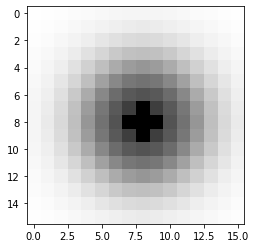

In [440]:
movie_seq = testNP[19]
dim = int(np.sqrt(movie_seq.shape[1]))
Input = movie_seq[:(movie_seq.shape[0]-1)]
Output = movie_seq[1:]
Input2 = Input.reshape((Input.shape[0],dim,dim)) #just reshape to make region of interest indices more natural
movie_length = Input2.shape[0]

center = (dim/2)*np.ones((2,movie_length,learnPhi.shape[2])) #shape 2tk (2 since center is 2-vector). initialize centers at center of image. each center is 2-vector
radius2 = ((dim/2-4))*np.ones((movie_length,learnPhi.shape[2])) # shape tk.initialize radius2 at 17^2, so start off region of interest as entire image
local_matrix = np.empty((center.shape[2], movie_length, dim,dim)) #shape is ktdd, where k is number of transforms, t is time, d is dim of image

for k in range(center.shape[2]):
    for t in range(movie_length):
        for i in range(dim):
            for j in range(dim):
                z = (np.linalg.norm(np.array([i,j])-center[:,t,k]) - radius2[t,k])/epsilon
                if z <= -1:
                    local_matrix[k,t,i,j] = 1
                else:
                    local_matrix[k,t,i,j] = 1 - norm.cdf(z)

plt.imshow(local_matrix[0,0,:,:], cmap='Greys')


In [417]:
coord_mat = np.empty((2,center.shape[2], movie_length, dim, dim)) #shape 2ktdd
for k in range(center.shape[2]):
    for t in range(movie_length):
        for i in range(dim):
            for j in range(dim):
                coord_mat[:,k,t,i,j] = np.array([i,j])
# center_mat = np.multiply(np.expand_dims(np.expand_dims(np.swapaxes(center,1,2),3),4), np.ones((2,center.shape[2],center.shape[1], dim, dim)))
# reslt = diff_mat - center_mat


In [430]:
# normdiff = np.linalg.norm(diffMatNP(movie_length, dim, center, radius2, coord_mat), axis = 0)
# radius_mat = np.multiply(np.expand_dims(np.expand_dims(np.swapaxes(radius2,0,1),3),4), np.ones((center.shape[2],center.shape[1], dim, dim)))
# z_mat = (normdiff - radius_mat)/epsilon
# z_mat[z_mat < -1]= 1
# zmask = z_mat[z_mat >= -1 ]
# z_mat[zmask]= (1 - norm.cdf(z_mat))[zmask]


C:\Users\frank\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


IndexError: arrays used as indices must be of integer (or boolean) type

In [427]:
def diffMatNP(movie_length, dim, center, radius2, coord_mat):    
    center_mat = np.multiply(np.expand_dims(np.expand_dims(np.swapaxes(center,1,2),3),4), np.ones((2,center.shape[2],center.shape[1], dim, dim)))
    diff_mat = coord_mat - center_mat 
                        
    return(diff_mat)

# def localImageNP(Input2, movie_length, dim, center, radius2, epsilon):
#     local_matrix = np.empty((center.shape[2], movie_length, dim,dim)) #shape is ktdd, where k is number of transforms, t is time, d is dim of image
    
#     for k in range(center.shape[2]):
#         for t in range(movie_length):
#             for i in range(dim):
#                 for j in range(dim):
#                     z = (np.linalg.norm(np.array([i,j])-center[:,t,k]) - radius2[t,k])/epsilon
#                     if z <= -1:
#                         local_matrix[k,t,i,j] = 1
#                     else:
#                         local_matrix[k,t,i,j] = 1 - norm.cdf(z)
#     local_matrix[k,t,i,j] = np.linalg.norm(np.array([i,j])-center[:,t,k])/radius2[t,k]
#     local_matrix[local_matrix <= 1] = 1
#     local_matrix[(local_matrix > 1) & (local_matrix <= 1+epsilon)] = .25
#     local_matrix[local_matrix > 1+epsilon] = 0
def localImageNP(Input2, movie_length, dim, center, radius2, epsilon, coord_mat):
    normdiff = np.linalg.norm(diffMatNP(movie_length, dim, center, radius2, dist_mat, coord_mat), axis = 0)
    radius_mat = np.multiply(np.expand_dims(np.expand_dims(np.swapaxes(radius2,0,1),3),4), np.ones((center.shape[2],center.shape[1], dim, dim)))
    z_mat = (normdiff - radius_mat)/epsilon
    z_mat[z_mat < -1]= 1
    z_mat[z_mat >= -1 ]= 1 - norm.cdf(z_mat)


    
    LocalInput2 = np.multiply(local_matrix, Input2)
    
    return(LocalInput2)


In [439]:
def norm_densNP(x ,epsilon):
    z = (1/np.sqrt(2*np.pi*epsilon))*np.exp((-(x**2))/(2*epsilon**2))
    return(z)

def diffMatNP(movie_length, dim, center, radius2):    
    diff_mat = np.empty((2,center.shape[2], movie_length, dim, dim)) #shape 2ktdd
    
    for k in range(center.shape[2]):
        for t in range(movie_length):
            for i in range(dim):
                for j in range(dim):
                    diff_mat[:,k,t,i,j] = (np.array([i,j])-center[:,t,k])

                        
    return(diff_mat)

def localImageNP(Input2, movie_length, dim, center, radius2, epsilon):
    local_matrix = np.empty((center.shape[2], movie_length, dim,dim)) #shape is ktdd, where k is number of transforms, t is time, d is dim of image
    
    for k in range(center.shape[2]):
        for t in range(movie_length):
            for i in range(dim):
                for j in range(dim):
                    z = (np.linalg.norm(np.array([i,j])-center[:,t,k]) - radius2[t,k])/epsilon
                    if z <= -1:
                        local_matrix[k,t,i,j] = 1
                    else:
                        local_matrix[k,t,i,j] = 1 - norm.cdf(z)
#     local_matrix[k,t,i,j] = np.linalg.norm(np.array([i,j])-center[:,t,k])/radius2[t,k]
#     local_matrix[local_matrix <= 1] = 1
#     local_matrix[(local_matrix > 1) & (local_matrix <= 1+epsilon)] = .25
#     local_matrix[local_matrix > 1+epsilon] = 0

    
    LocalInput2 = np.multiply(local_matrix, Input2)
    
    return(LocalInput2)

def InferNbdNP(Input2, center, Output, radius2, phi, beta, eta3, eta4, epsilon, attStep, movie_length, dim):
    for step in range(attStep):
        localimg = localImageNP(Input2, movie_length, dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input2.shape[1]**2)) #calculate localized images and reshape. ktn2
        Input3 = Input2.reshape(Input2.shape[0], Input2.shape[1]**2)
        
        predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, localimg, optimize = True)
        error = Output - squashNP(predictions)
        dTanh = squash_derivNP(predictions)
        diff = diffMatNP(movie_length, dim, center, radius2)
        dist = np.linalg.norm(diff,axis=0)+.01
        rad_mat = np.ones_like(dist)
        rad_mat = np.multiply(rad_mat,np.expand_dims(np.expand_dims(radius2.T, axis=2), axis = 3)) #array where kt is radius over all ij entries
#         PD_1 = norm_densNP(3*epsilon + dist, epsilon)
        PD_2 = norm_densNP(dist-rad_mat, epsilon)
        PD_3 = np.multiply(PD_2, diff/dist).reshape((2,center.shape[2],movie_length, Input2.shape[1]**2))                
        centerPD = np.multiply(Input3, PD_3)
        radPD = np.multiply(Input3, PD_2.reshape(center.shape[2],movie_length, Input2.shape[1]**2)) #radius partial deriv
        
#No need for 1/epsilon since it's already included in the normal density function. Calc in white notebook is standard normal
#times 1/epsilon, where 1/ep gives the correct normalizing constant
        delta = np.einsum('ti,ti -> ti', error, dTanh)
        dR = np.einsum('ti, tk, ijk, ktj -> tk', delta, beta, phi, radPD, optimize= True)
        radius2 += eta3*dR
        dC = np.einsum('ti, tk, ijk, cktj -> ctk', delta, beta, phi, centerPD, optimize = True)
        center += eta4*dC
    return(radius2,center)

def InferBeta2NP(Input2, center, Output, radius2, phi ,beta, eta, epsilon, betaStep, movie_length, dim):
    
    for step in range(betaStep):
        
        localimg = localImageNP(Input2, Input2.shape[0], dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input2.shape[1]**2)) #calculate localized images and reshape
        
        predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, localimg, optimize=True)
        error = Output - squashNP(predictions)
        dTanh = squash_derivNP(predictions)
        delta = np.einsum('ti,ti -> ti', error, dTanh)
        dBeta = np.einsum('ti,ijk, ktj -> tk', delta, phi, localimg, optimize=True) - sparsePen*sparseDerivNP(np.expand_dims(beta,axis=0))[0,:,:] - derivPen*timeDerivNP(np.expand_dims(beta,axis=0))[0,:,:]
        #just a bit of reshaping magic above to make the functions work, since sparse/derivPen made for data with extra batch dim
        beta += eta2*dBeta
    
    return(beta)

def InferLocalNP(movie_seq, phi, sparsePen, derivPen, eta2, eta3, eta4, betaStep, attStep, numInference): 
    #now want to infer beta, center, and radii for a single movie sequence
    #***RADII ARE SQUARED, to make computing the derivative easier***
    #assume movie sequence is shape txn2, where t is length (movie_length) and n2 is product of dimensions of 2d image
    
    dim = int(np.sqrt(movie_seq.shape[1]))
    Input = movie_seq[:(movie_seq.shape[0]-1)]
    Output = movie_seq[1:]
    Input2 = Input.reshape((Input.shape[0],dim,dim)) #just reshape to make region of interest indices more natural
    movie_length = Input2.shape[0]
    
    beta = np.zeros((Input2.shape[0],phi.shape[2])) #initialize beta at 0. beta is shape tk. movie_seq first dim is t
    center = (dim/2)*np.ones((2,movie_length,phi.shape[2])) #shape 2tk (2 since center is 2-vector). initialize centers at center of image. each center is 2-vector
    radius2 = ((dim/2-4))*np.ones((movie_length,phi.shape[2])) # shape tk.initialize radius2 at 17^2, so start off region of interest as entire image
    
    eta3_phase2 = eta3*.5
    eta4_phase2 = eta4*.5
    for bigStep in range(numInference):
#         if bigStep < numInference/2:
#             pass
#         else:
#             eta3 = eta3_phase2
#             eta4 = eta4_phase2
        beta = InferBeta2NP(Input2, center, Output, radius2, phi ,beta, eta, epsilon, betaStep, movie_length, dim)
        radius2, center = InferNbdNP(Input2, center, Output, radius2, phi, beta, eta3, eta4, epsilon, attStep, movie_length, dim)
        print(bigStep, end = '\r')
    
    finalImg = localImageNP(Input2, movie_length, dim, center, radius2, epsilon).reshape((center.shape[2],movie_length, Input.shape[1]))
    final_predictions = np.einsum('tk,ijk,ktj -> ti', beta, phi, finalImg, optimize = True)
    
    fig = plt.figure(figsize = (20,6)) #plot the figures, top is ground truth, bottom is predictions
    for i in range(movie_length):
        for j in range(2):
            fig.add_subplot(2,movie_length,movie_length*j+i+1)
            if j == 0:
                plt.imshow(Output[i].reshape((dim,dim)),cmap = "Greys")
            else: 
                plt.imshow(final_predictions[i].reshape((dim,dim)),cmap="Greys")
    
    return((beta,radius2,center))

In [455]:
numTransforms = 16
trainSteps = 1500
batchSize = 25 #training 
sparsePen = 4
derivPen = 2
epsilon = 3 #variance of normal desntiy in the smoothed bump function.
eta = .01 #learning rate of phi, the dictionary of transforms
eta2 = .015 #learning rate of beta, the transform coeff
eta3 = .5 #Learning rate of radii
eta4 =  1 #Learning rate of center
numInference = 150 #arbitrary
numInf2 = 15
betaStep = 5 #FOR TRAINED TRANSFORMS. mini cycle for beta
attStep =  10 #FOR TRAINED TRANSFORMS. mini cycle for center/radii

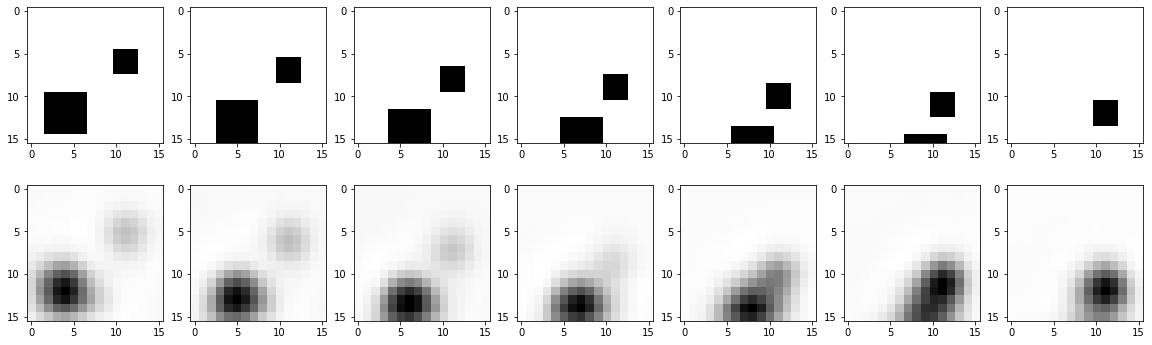

In [466]:
#example where algo works with no attention
datanum = 28
test_raw = test[datanum].unsqueeze(0)
dim = test_raw.size()[2]     
test_rawIn = test_raw[:,:(test_raw.size()[1]-1),:] #will predict next frame from these
test_rawOut = test_raw[:,1:,:] #the frames to be predicted
movie_length = test_rawIn.size(1)

test_rawBeta = inferBeta(test_rawIn, test_rawOut, learnPhi, sparsePen, derivPen, eta2)
test_rawPred = torch.einsum('btk,ijk,btj -> bti', test_rawBeta, learnPhi, test_rawIn)
test_rawPred = test_rawPred.squeeze(0)
test_rawPredNP = torch.Tensor.numpy(torch.Tensor.cpu(test_rawPred))


fig = plt.figure(figsize = (20,6)) #plot the figures, top is ground truth, bottom is predictions
for i in range(movie_length):
    for j in range(2):
        fig.add_subplot(2,movie_length,movie_length*j+i+1)
        if j == 0:
            plt.imshow(testNP[datanum,i+1].reshape((16,16)),cmap = "Greys")
        else: 
            plt.imshow(test_rawPredNP[i].reshape((16,16)),cmap="Greys")


In [467]:
#this run was for 25 total cycles, 10/10 per beta/attention. learning center/rad were .05/.1. Epsilon set to 3. 
testrun = InferLocalNP(testNP[30], learnPhiNP, sparsePen, derivPen, eta2, eta3, eta4, betaStep, attStep, numInf2)

KeyboardInterrupt: 

Text(0, 0.5, 'column')

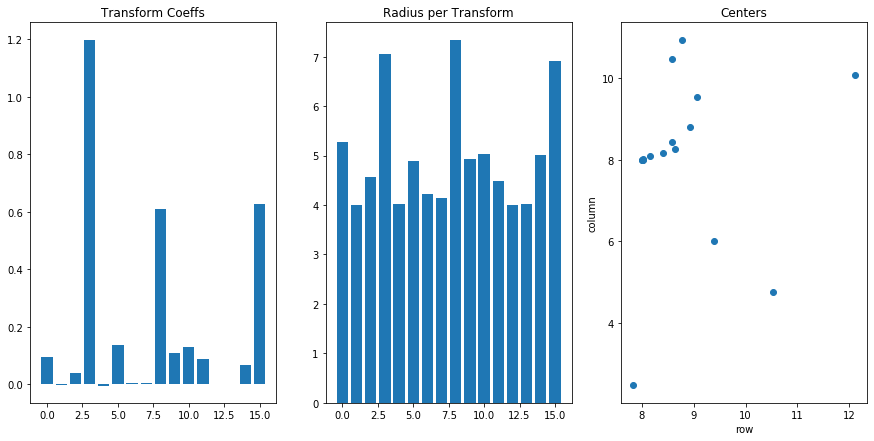

In [450]:
#this run was for 60 total cycles, 5/5 per beta/attention. learning center/rad were .05/.1. Epsilon set to 1. frame = 4
frame = 0
fig_testrun = plt.figure(figsize=(15,7)) #image sequence from dataset
ax1 = fig_testrun.add_subplot(1,3,1)
ax1.bar(list(range(16)), (testrun[0])[frame,:])
ax1.title.set_text('Transform Coeffs')
ax2 = fig_testrun.add_subplot(1,3,2)
ax2.bar(list(range(16)), (testrun[1])[frame,:])
ax2.title.set_text('Radius per Transform')
ax3 = fig_testrun.add_subplot(1,3,3)
ax3.scatter((testrun[2])[0,frame,:],(testrun[2])[1,frame,:])
ax3.title.set_text('Centers')
ax3.set_xlabel('row')
ax3.set_ylabel('column')

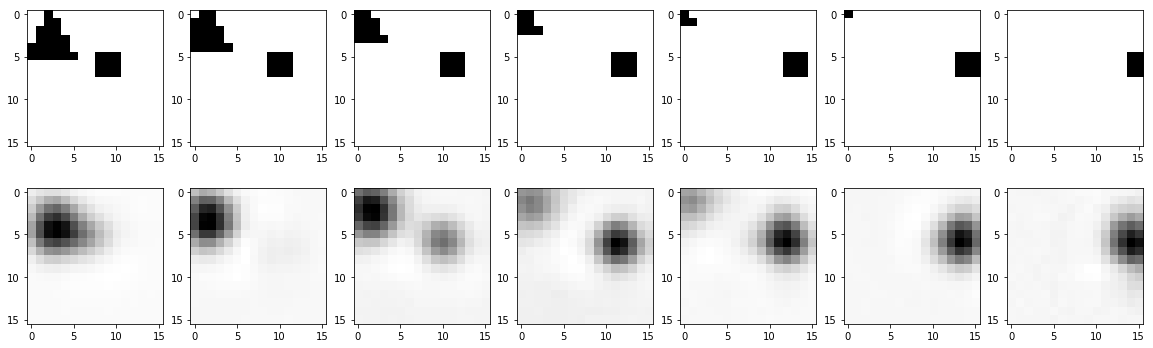

In [98]:
#example where algo works with no attention
datanum = 13
test_raw = test[datanum].unsqueeze(0)
dim = test_raw.size()[2]     
test_rawIn = test_raw[:,:(test_raw.size()[1]-1),:] #will predict next frame from these
test_rawOut = test_raw[:,1:,:] #the frames to be predicted
movie_length = test_rawIn.size(1)

test_rawBeta = inferBeta(test_rawIn, test_rawOut, learnPhi, sparsePen, derivPen, eta2)
test_rawPred = torch.einsum('btk,ijk,btj -> bti', test_rawBeta, learnPhi, test_rawIn)
test_rawPred = test_rawPred.squeeze(0)
test_rawPredNP = torch.Tensor.numpy(torch.Tensor.cpu(test_rawPred))


fig = plt.figure(figsize = (20,6)) #plot the figures, top is ground truth, bottom is predictions
for i in range(movie_length):
    for j in range(2):
        fig.add_subplot(2,movie_length,movie_length*j+i+1)
        if j == 0:
            plt.imshow(testNP[datanum,i+1].reshape((16,16)),cmap = "Greys")
        else: 
            plt.imshow(test_rawPredNP[i].reshape((16,16)),cmap="Greys")


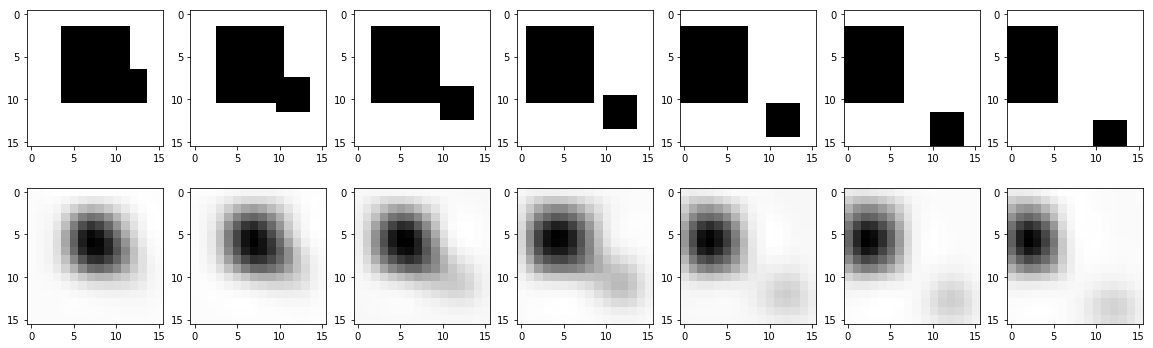

In [70]:
#example where algo has hard time tracking two objects
datanum = 7
test_raw = test[datanum].unsqueeze(0)
dim = test_raw.size()[2]     
test_rawIn = test_raw[:,:(test_raw.size()[1]-1),:] #will predict next frame from these
test_rawOut = test_raw[:,1:,:] #the frames to be predicted
movie_length = test_rawIn.size(1)

test_rawBeta = inferBeta(test_rawIn, test_rawOut, learnPhi, sparsePen, derivPen, eta2)
test_rawPred = torch.einsum('btk,ijk,btj -> bti', test_rawBeta, learnPhi, test_rawIn)
test_rawPred = test_rawPred.squeeze(0)
test_rawPredNP = torch.Tensor.numpy(torch.Tensor.cpu(test_rawPred))


fig = plt.figure(figsize = (20,6)) #plot the figures, top is ground truth, bottom is predictions
for i in range(movie_length):
    for j in range(2):
        fig.add_subplot(2,movie_length,movie_length*j+i+1)
        if j == 0:
            plt.imshow(testNP[datanum,i+1].reshape((16,16)),cmap = "Greys")
        else: 
            plt.imshow(test_rawPredNP[i].reshape((16,16)),cmap="Greys")


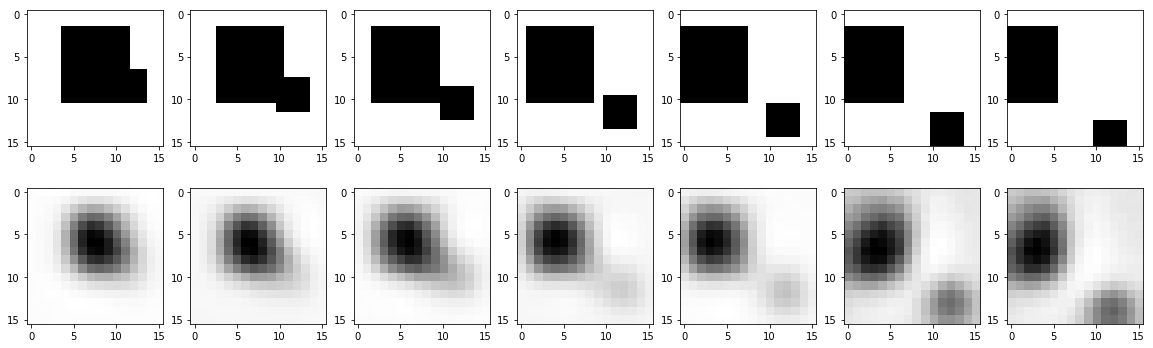

In [92]:
#this run was for 60 total cycles, 5/5 per beta/attention. learning center/rad were .05/.1. Epsilon set to 1. 
testrun = InferLocalNP(testNP[7], learnPhiNP, sparsePen, derivPen, eta2, eta3, eta4, betaStep, attStep, numInf2)

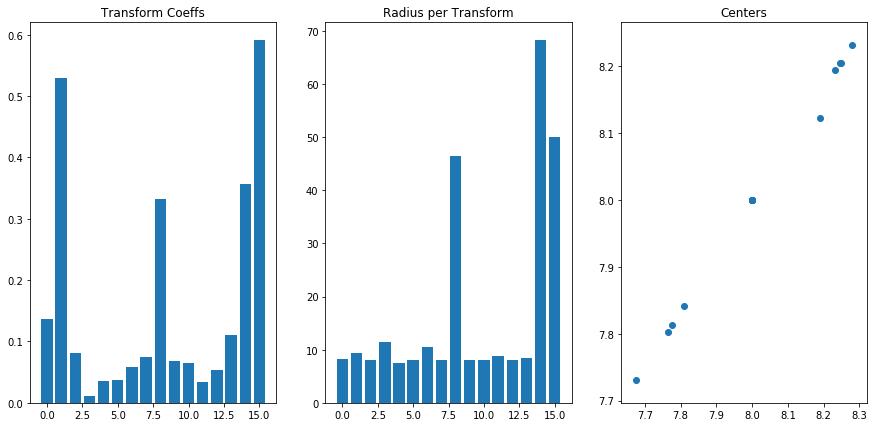

In [96]:
#this run was for 60 total cycles, 5/5 per beta/attention. learning center/rad were .05/.1. Epsilon set to 1. frame = 4
frame = 2
fig_testrun = plt.figure(figsize=(15,7)) #image sequence from dataset
ax1 = fig_testrun.add_subplot(1,3,1)
ax1.bar(list(range(16)), (testrun[0])[frame,:])
ax1.title.set_text('Transform Coeffs')
ax2 = fig_testrun.add_subplot(1,3,2)
ax2.bar(list(range(16)), (testrun[1])[frame,:])
ax2.title.set_text('Radius per Transform')
ax3 = fig_testrun.add_subplot(1,3,3)
ax3.scatter((testrun[2])[0,frame,:],(testrun[2])[1,frame,:])
ax3.title.set_text('Centers')

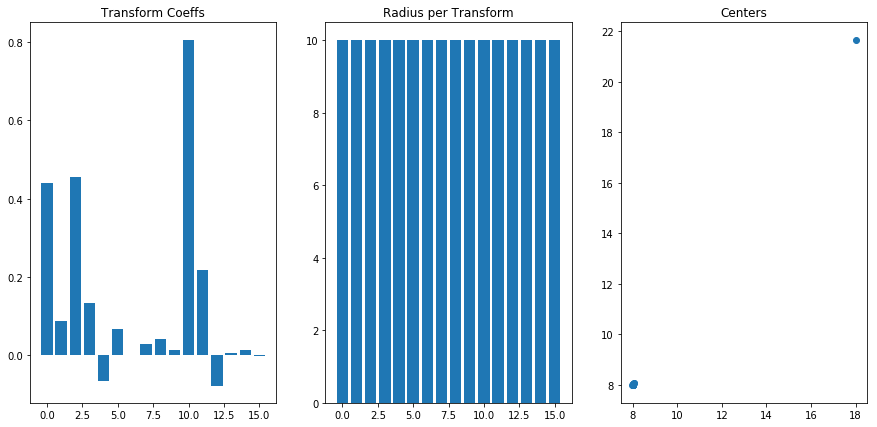

In [97]:
#this run was for 60 total cycles, 5/5 per beta/attention. learning center/rad were .05/.1. Epsilon set to 1. frame = 4
frame = 5
fig_testrun = plt.figure(figsize=(15,7)) #image sequence from dataset
ax1 = fig_testrun.add_subplot(1,3,1)
ax1.bar(list(range(16)), (testrun[0])[frame,:])
ax1.title.set_text('Transform Coeffs')
ax2 = fig_testrun.add_subplot(1,3,2)
ax2.bar(list(range(16)), (testrun[1])[frame,:])
ax2.title.set_text('Radius per Transform')
ax3 = fig_testrun.add_subplot(1,3,3)
ax3.scatter((testrun[2])[0,frame,:],(testrun[2])[1,frame,:])
ax3.title.set_text('Centers')

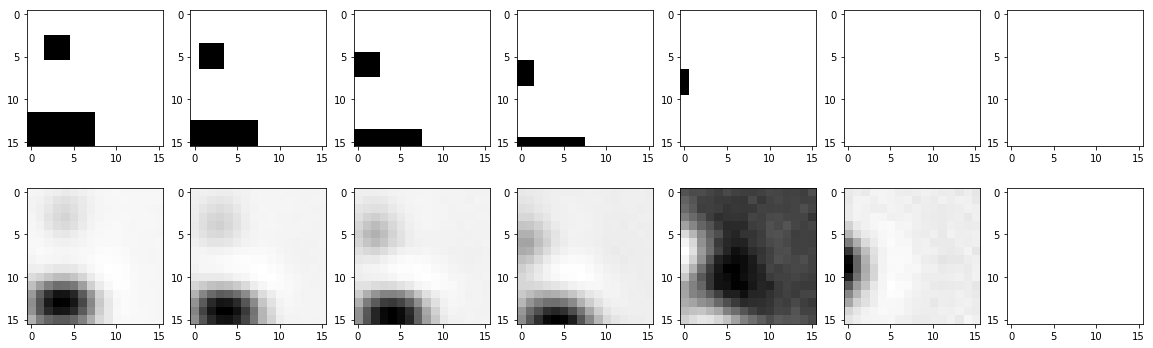

In [101]:
#algo has trouble attending to two objects. seems to invert colors at frame 5.
datanum = 1
test_raw = test[datanum].unsqueeze(0)
dim = test_raw.size()[2]     
test_rawIn = test_raw[:,:(test_raw.size()[1]-1),:] #will predict next frame from these
test_rawOut = test_raw[:,1:,:] #the frames to be predicted
movie_length = test_rawIn.size(1)

test_rawBeta = inferBeta(test_rawIn, test_rawOut, learnPhi, sparsePen, derivPen, eta2)
test_rawPred = torch.einsum('btk,ijk,btj -> bti', test_rawBeta, learnPhi, test_rawIn)
test_rawPred = test_rawPred.squeeze(0)
test_rawPredNP = torch.Tensor.numpy(torch.Tensor.cpu(test_rawPred))


fig = plt.figure(figsize = (20,6)) #plot the figures, top is ground truth, bottom is predictions
for i in range(movie_length):
    for j in range(2):
        fig.add_subplot(2,movie_length,movie_length*j+i+1)
        if j == 0:
            plt.imshow(testNP[datanum,i+1].reshape((16,16)),cmap = "Greys")
        else: 
            plt.imshow(test_rawPredNP[i].reshape((16,16)),cmap="Greys")


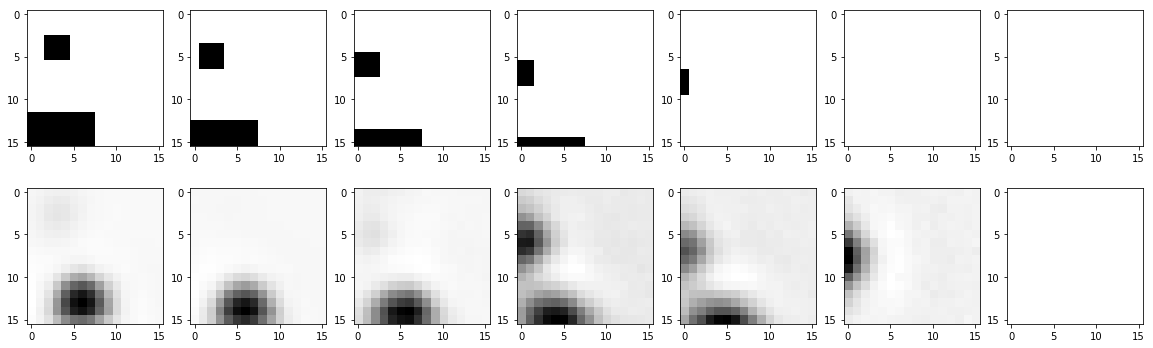

In [105]:
#this run was for 100 total cycles, 5/5 per beta/attention. learning center/rad were .05/.1. Epsilon set to 1. 
testrun2 = InferLocalNP(testNP[1], learnPhiNP, sparsePen, derivPen, eta2, eta3, eta4, betaStep, attStep, numInf2)

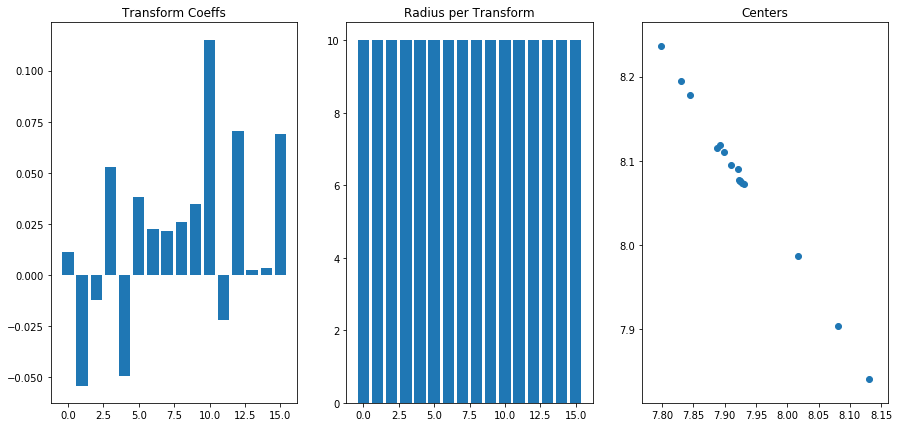

In [108]:
#this run was for 60 total cycles, 5/5 per beta/attention. learning center/rad were .05/.1. Epsilon set to 1. frame = 4
frame = 3
fig_testrun2 = plt.figure(figsize=(15,7)) #image sequence from dataset
ax1 = fig_testrun2.add_subplot(1,3,1)
ax1.bar(list(range(16)), (testrun2[0])[frame,:])
ax1.title.set_text('Transform Coeffs')
ax2 = fig_testrun2.add_subplot(1,3,2)
ax2.bar(list(range(16)), (testrun2[1])[frame,:])
ax2.title.set_text('Radius per Transform')
ax3 = fig_testrun2.add_subplot(1,3,3)
ax3.scatter((testrun2[2])[0,frame,:],(testrun2[2])[1,frame,:])
ax3.title.set_text('Centers')

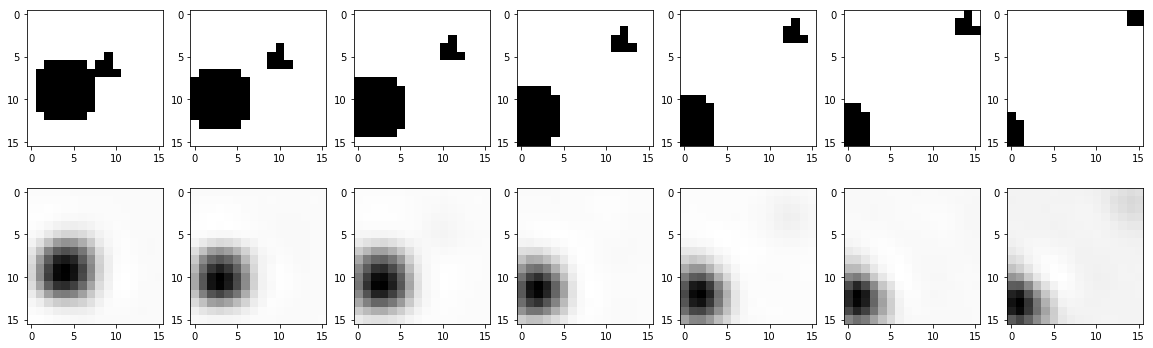

In [125]:
#algo ignores one of the objects
datanum = 17
test_raw = test[datanum].unsqueeze(0)
dim = test_raw.size()[2]     
test_rawIn = test_raw[:,:(test_raw.size()[1]-1),:] #will predict next frame from these
test_rawOut = test_raw[:,1:,:] #the frames to be predicted
movie_length = test_rawIn.size(1)

test_rawBeta = inferBeta(test_rawIn, test_rawOut, learnPhi, sparsePen, derivPen, eta2)
test_rawPred = torch.einsum('btk,ijk,btj -> bti', test_rawBeta, learnPhi, test_rawIn)
test_rawPred = test_rawPred.squeeze(0)
test_rawPredNP = torch.Tensor.numpy(torch.Tensor.cpu(test_rawPred))


fig = plt.figure(figsize = (20,6)) #plot the figures, top is ground truth, bottom is predictions
for i in range(movie_length):
    for j in range(2):
        fig.add_subplot(2,movie_length,movie_length*j+i+1)
        if j == 0:
            plt.imshow(testNP[datanum,i+1].reshape((16,16)),cmap = "Greys")
        else: 
            plt.imshow(test_rawPredNP[i].reshape((16,16)),cmap="Greys")


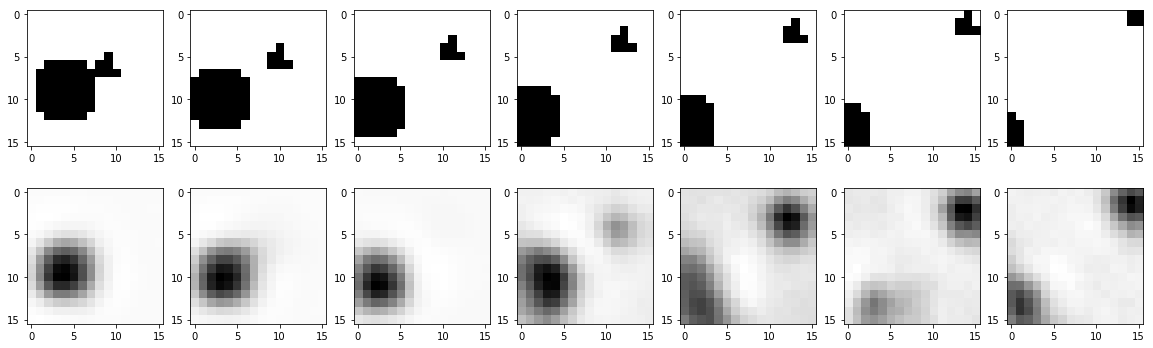

In [129]:
#this run was for 100 total cycles, 5/5 per beta/attention. learning center/rad were .05/.1. Epsilon set to 1. 
testrun3 = InferLocalNP(testNP[17], learnPhiNP, sparsePen, derivPen, eta2, eta3, eta4, betaStep, attStep, numInf2)

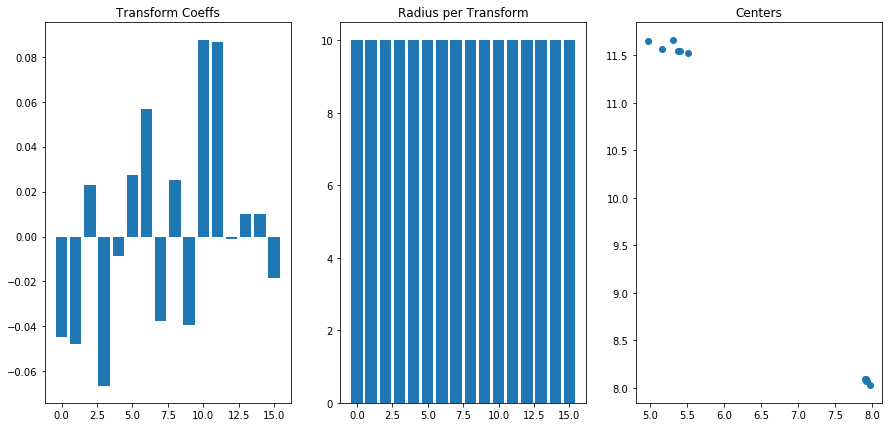

In [131]:
#this run was for 60 total cycles, 5/5 per beta/attention. learning center/rad were .05/.1. Epsilon set to 1. frame = 4
frame = 5
fig_testrun3 = plt.figure(figsize=(15,7)) #image sequence from dataset
ax1 = fig_testrun3.add_subplot(1,3,1)
ax1.bar(list(range(16)), (testrun3[0])[frame,:])
ax1.title.set_text('Transform Coeffs')
ax2 = fig_testrun3.add_subplot(1,3,2)
ax2.bar(list(range(16)), (testrun3[1])[frame,:])
ax2.title.set_text('Radius per Transform')
ax3 = fig_testrun3.add_subplot(1,3,3)
ax3.scatter((testrun3[2])[0,frame,:],(testrun3[2])[1,frame,:])
ax3.title.set_text('Centers')

In [ ]:
#plot out the centers, frame to frame.
#also animate action of each phi_k to a localize window, for different centers and radii.